<a href="https://colab.research.google.com/github/atick-faisal/MultiViewUNet-TAVI/blob/dev/src/training/TAVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Runtime Config

In [1]:
LOCAL_MACHINE = False

In [2]:
from psutil import virtual_memory

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)


ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Mon Nov 27 11:39:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fix G-Drive

In [3]:
import os

if not LOCAL_MACHINE:
    print("Installing G-Drive ... ")
    os.system("pip install -U --no-cache-dir gdown --pre > /dev/null")
    print("Install Pix2Pix")
    os.system("pip install git+https://github.com/tensorflow/examples.git")

Installing G-Drive ... 
Install Pix2Pix


# Mount G-Drive

In [4]:
if not LOCAL_MACHINE:
    from google.colab import drive

    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download and Extract Dataset

In [5]:
if not LOCAL_MACHINE:
    print("Downloading Dataset ... ")
    os.system("gdown 1xBO079FPIeE7T5VVsFwc8QeZxAfS4J9O")
    print("Extracting Dataset ... ")
    os.system('unzip -o "TAVI_REG_r17.zip" > /dev/null')

Extracting Dataset ... 


# Imports

In [6]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

from tensorflow_examples.models.pix2pix import pix2pix

# Problem Config

In [7]:
PROBLEM = "Curvature_2_Pressure"

MODEL_NAME = "MultiViewUNet"
DATASET_PATH = "/content/Images/"
TRAIN_DIR = "Train/"
TEST_DIR = "Test/"
INPUT_DIR = PROBLEM.split("_2_")[0]
TARGET_DIR = PROBLEM.split("_2_")[1]
MODEL_PATH = "/content/drive/MyDrive/Research/TAVI/Models/"
PRED_PATH = "/content/drive/MyDrive/Research/TAVI/Predictions/"
IMG_SIZE = 256
BATCH_SIZE = 16
BUFFER_SIZE = 1000
VAL_SPLIT = 0.2
LEARNING_RATE = 0.001
N_EPOCHS = 300
PATIENCE = 30
DROPOUT = 0.5

EXP_NAME = f"{PROBLEM}_{MODEL_NAME}_DO_{DROPOUT}"

# Architecture

## Vanilla UNet

In [8]:
class UNet:
    def __init__(
        self,
        img_size: int,
        n_channels: int = 3,
        width: int = 32,
        depth: int = 4,
        kernel_size: int = 3,
    ):
        self.img_size = img_size
        self.n_channels = n_channels
        self.width = width
        self.depth = depth
        self.kernel_size = kernel_size

    @staticmethod
    def conv(x: tf.Tensor, filters: int, kernel_size: int) -> tf.Tensor:
        for i in range(2):
            x = tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                strides=1,
                padding="same",
                data_format="channels_last",
                dilation_rate=1,
                groups=1,
                activation=None,
                use_bias=True,
                kernel_initializer="glorot_uniform",
                bias_initializer="zeros",
            )(x)

            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)

        return x

    @staticmethod
    def deconv(x: tf.Tensor, filters: int) -> tf.Tensor:
        x = tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=2,
            strides=2,
            padding="same",
            output_padding=None,
            data_format=None,
            dilation_rate=1,
            activation=None,
            use_bias=True,
            kernel_initializer="glorot_uniform",
            bias_initializer="zeros",
        )(x)

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

        return x

    @staticmethod
    def output(x: tf.Tensor) -> tf.Tensor:
        return tf.keras.layers.Conv2D(3, (1, 1), activation="sigmoid")(x)

    @staticmethod
    def pool(x: tf.Tensor, pool_size: int = 2) -> tf.Tensor:
        return tf.keras.layers.MaxPool2D(pool_size)(x)

    @staticmethod
    def dropout(x: tf.Tensor, amount: float = 0.5) -> tf.Tensor:
        return tf.keras.layers.Dropout(amount)(x)

    def __call__(self) -> tf.keras.Model:
        inputs = tf.keras.layers.Input(
            shape=(self.img_size, self.img_size, self.n_channels)
        )

        # scaled = tf.keras.layers.Rescaling(1./255.0, offset=0)(inputs)

        # ------------------ Downsampling ---------------------
        downsample_layers = []
        downsample_layers.append(
            self.conv(x=inputs, filters=self.width,
                      kernel_size=self.kernel_size)
        )
        for i in range(1, self.depth):
            dropout_amount = 0.2 if i == 1 else DROPOUT
            filters = int((2**i) * self.width)
            downsample_layers.append(
                self.dropout(
                    self.pool(
                        self.conv(
                            x=downsample_layers[i - 1],
                            filters=filters,
                            kernel_size=self.kernel_size,
                        )
                    ),
                    amount=dropout_amount,
                )
            )

        # ------------------- Features --------------------
        n_features = int((2**self.depth) * self.width)
        self.features = self.pool(
            self.conv(
                x=downsample_layers[-1],
                filters=n_features,
                kernel_size=self.kernel_size,
            )
        )

        # ------------------- Upsampling --------------------
        upsample_layers = []
        upsample_layers.append(self.features)
        for i in range(1, self.depth + 1):
            filters = int((2 ** (self.depth - i)) * self.width)
            upsample_layers.append(
                self.conv(
                    x=self.dropout(
                        tf.keras.layers.concatenate(
                            [
                                downsample_layers[self.depth - i],
                                self.deconv(
                                    x=upsample_layers[i - 1], filters=filters),
                            ]
                        ),
                        amount=0.2
                    ),
                    filters=filters,
                    kernel_size=self.kernel_size,
                )
            )

        # ---------------------- Output -----------------------
        outputs = self.output(upsample_layers[-1])

        return tf.keras.Model(inputs, outputs)

# UNet - MobileNetv2

In [9]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[IMG_SIZE, IMG_SIZE, 3], include_top=False
)

# Use the activations of these layers
layer_names = [
    "block_1_expand_relu",  # 112x112
    "block_3_expand_relu",  # 56x56
    "block_6_expand_relu",  # 28x28
    "block_13_expand_relu",  # 14x14
    "block_16_project",  # 7x7
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = True

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),  # 32x32 -> 64x64
]


def unet_model(output_channels: int = 3):
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="sigmoid",
    )  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Loss Functions / Metrics

In [10]:
def attention_mse(y_true, y_pred):
    _y_true = y_true[y_true != 1.0]
    _y_pred = y_pred[y_true != 1.0]
    squared_difference = tf.square(_y_true - _y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)


def attention_mae(y_true, y_pred):
    _y_true = y_true[y_true != 1.0]
    _y_pred = y_pred[y_true != 1.0]
    squared_difference = tf.abs(_y_true - _y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

# Data Loader

In [11]:
def load_data_from_dir(path: str) -> tf.data.Dataset:
    return tf.keras.utils.image_dataset_from_directory(
        directory=path,
        labels=None,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=False,
        seed=42,
        interpolation="bilinear",
        follow_links=False,
        crop_to_aspect_ratio=False,
    )

# Load Dataset

In [12]:
trainX = load_data_from_dir(os.path.join(DATASET_PATH, TRAIN_DIR, INPUT_DIR))
trainY = load_data_from_dir(os.path.join(DATASET_PATH, TRAIN_DIR, TARGET_DIR))
testX = load_data_from_dir(os.path.join(DATASET_PATH, TEST_DIR, INPUT_DIR))
testY = load_data_from_dir(os.path.join(DATASET_PATH, TEST_DIR, TARGET_DIR))

train_ds = tf.data.Dataset.zip((trainX, trainY))
test_ds = tf.data.Dataset.zip((testX, testY))

print(train_ds.element_spec)
print(test_ds.element_spec)

Found 432 files belonging to 1 classes.
Found 432 files belonging to 1 classes.
Found 96 files belonging to 1 classes.
Found 96 files belonging to 1 classes.
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


# Normalization

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_ds = train_ds.map(lambda x, y: (
    normalization_layer(x), normalization_layer(y)))
test_ds = test_ds.map(lambda x, y: (
    normalization_layer(x), normalization_layer(y)))

# Optimization

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_batches = train_ds.cache().shuffle(
    BUFFER_SIZE).prefetch(buffer_size=AUTOTUNE)
test_batches = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training Config

In [15]:
model_path = os.path.join(MODEL_PATH, EXP_NAME)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=PATIENCE, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
    ),
]

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model = UNet(IMG_SIZE)()
# model = unet_model()

model.compile(loss=attention_mse, optimizer=optimizer, metrics=[attention_mae])

# Load Saved Weights

In [16]:
# try:
#     model.load_weights(model_path)
# except:
#     print("Checkpoint not found")
#     pass

# Training

In [17]:
history = model.fit(
    train_batches,
    validation_data=test_batches,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/300
27/27 [==============================] - ETA: 0s - loss: 0.0252 - attention_mae: 0.1095
Epoch 1: val_loss improved from inf to 0.09143, saving model to /content/drive/MyDrive/Research/TAVI/Models/Curvature_2_Pressure_MultiViewUNet_DO_0.5
27/27 [==============================] - 58s 438ms/step - loss: 0.0252 - attention_mae: 0.1095 - val_loss: 0.0914 - val_attention_mae: 0.2517
Epoch 2/300
27/27 [==============================] - ETA: 0s - loss: 0.0117 - attention_mae: 0.0685
Epoch 2: val_loss improved from 0.09143 to 0.09000, saving model to /content/drive/MyDrive/Research/TAVI/Models/Curvature_2_Pressure_MultiViewUNet_DO_0.5
27/27 [==============================] - 7s 271ms/step - loss: 0.0117 - attention_mae: 0.0685 - val_loss: 0.0900 - val_attention_mae: 0.2278
Epoch 3/300
27/27 [==============================] - ETA: 0s - loss: 0.0102 - attention_mae: 0.0592
Epoch 3: val_loss improved from 0.09000 to 0.05138, saving model to /content/drive/MyDrive/Research/TAVI/Models/C

# Save Model

In [18]:
timestamp = datetime.datetime.now().strftime("%b-%d-%I:%M%p")
if not os.path.exists(model_path):
    os.makedirs(model_path)

model.save(os.path.join(model_path, timestamp))

# Save Predictions

In [19]:
test_ds_unbatched = test_batches.unbatch()

pred_path = os.path.join(PRED_PATH, EXP_NAME, timestamp)
if not os.path.exists(pred_path):
    os.makedirs(pred_path)

metrics = pd.DataFrame()

for idx, (input, target) in enumerate(tqdm(test_ds_unbatched)):
    target = tf.squeeze(target)
    prediction = tf.squeeze(model.predict(tf.expand_dims(input, axis=0)))

    channel_sum = tf.expand_dims(tf.reduce_sum(target, axis=-1), axis=-1)
    white_mask = tf.reduce_all(tf.equal(channel_sum, 3.0), axis=-1)
    expanded_mask = tf.expand_dims(white_mask, axis=-1)
    expanded_mask = tf.tile(expanded_mask, [1, 1, 3])
    prediction = tf.where(expanded_mask, tf.ones_like(prediction), prediction)

    target_pil = Image.fromarray(np.array(target * 255.0, dtype=np.uint8))
    prediction_pil = Image.fromarray(
        np.array(prediction * 255.0, dtype=np.uint8))

    target_pil.save(os.path.join(pred_path, f"{idx}_T.png"))
    prediction_pil.save(os.path.join(pred_path, f"{idx}_P.png"))

0it [00:00, ?it/s]

1/1 [==============================] - 1s 983ms/step


1it [00:01,  1.34s/it]

1/1 [==============================] - 0s 23ms/step


2it [00:01,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


3it [00:01,  2.58it/s]

1/1 [==============================] - 0s 25ms/step


4it [00:01,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


5it [00:01,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


6it [00:01,  5.40it/s]

1/1 [==============================] - 0s 34ms/step


7it [00:02,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


9it [00:02,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


10it [00:02,  7.66it/s]

1/1 [==============================] - 0s 22ms/step


11it [00:02,  8.02it/s]

1/1 [==============================] - 0s 25ms/step


12it [00:02,  7.96it/s]

1/1 [==============================] - 0s 23ms/step


13it [00:02,  8.34it/s]

1/1 [==============================] - 0s 28ms/step


14it [00:02,  8.52it/s]

1/1 [==============================] - 0s 24ms/step


15it [00:02,  8.56it/s]

1/1 [==============================] - 0s 23ms/step


16it [00:03,  8.58it/s]

1/1 [==============================] - 0s 26ms/step


17it [00:03,  8.58it/s]

1/1 [==============================] - 0s 25ms/step


18it [00:03,  8.69it/s]

1/1 [==============================] - 0s 22ms/step


19it [00:03,  8.85it/s]

1/1 [==============================] - 0s 26ms/step


20it [00:03,  8.69it/s]

1/1 [==============================] - 0s 30ms/step


21it [00:03,  8.18it/s]

1/1 [==============================] - 0s 23ms/step


22it [00:03,  8.24it/s]

1/1 [==============================] - 0s 26ms/step


23it [00:03,  8.44it/s]

1/1 [==============================] - 0s 26ms/step


24it [00:03,  8.61it/s]

1/1 [==============================] - 0s 22ms/step


25it [00:04,  8.71it/s]

1/1 [==============================] - 0s 25ms/step


26it [00:04,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


27it [00:04,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


28it [00:04,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


29it [00:04,  6.99it/s]

1/1 [==============================] - 0s 34ms/step


30it [00:04,  6.78it/s]

1/1 [==============================] - 0s 37ms/step


31it [00:04,  6.80it/s]

1/1 [==============================] - 0s 33ms/step


32it [00:05,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


33it [00:05,  7.06it/s]

1/1 [==============================] - 0s 33ms/step


34it [00:05,  7.13it/s]

1/1 [==============================] - 0s 31ms/step


35it [00:05,  7.21it/s]

1/1 [==============================] - 0s 31ms/step


36it [00:05,  7.07it/s]

1/1 [==============================] - 0s 31ms/step


37it [00:05,  7.23it/s]

1/1 [==============================] - 0s 32ms/step


38it [00:05,  7.12it/s]

1/1 [==============================] - 0s 43ms/step


39it [00:06,  6.76it/s]

1/1 [==============================] - 0s 30ms/step


40it [00:06,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


41it [00:06,  7.00it/s]

1/1 [==============================] - 0s 36ms/step


42it [00:06,  7.07it/s]

1/1 [==============================] - 0s 32ms/step


43it [00:06,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


44it [00:06,  6.98it/s]

1/1 [==============================] - 0s 35ms/step


45it [00:06,  6.80it/s]

1/1 [==============================] - 0s 33ms/step


46it [00:07,  6.72it/s]

1/1 [==============================] - 0s 85ms/step


47it [00:07,  6.19it/s]

1/1 [==============================] - 0s 34ms/step


48it [00:07,  6.18it/s]

1/1 [==============================] - 0s 35ms/step


49it [00:07,  6.36it/s]

1/1 [==============================] - 0s 38ms/step


50it [00:07,  6.20it/s]

1/1 [==============================] - 0s 36ms/step


51it [00:07,  5.91it/s]

1/1 [==============================] - 0s 34ms/step


52it [00:08,  5.93it/s]

1/1 [==============================] - 0s 34ms/step


53it [00:08,  6.03it/s]

1/1 [==============================] - 0s 40ms/step


54it [00:08,  5.85it/s]

1/1 [==============================] - 0s 34ms/step


55it [00:08,  5.78it/s]

1/1 [==============================] - 0s 34ms/step


56it [00:08,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


57it [00:09,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


58it [00:09,  5.28it/s]

1/1 [==============================] - 0s 36ms/step


59it [00:09,  5.24it/s]

1/1 [==============================] - 0s 32ms/step


60it [00:09,  5.70it/s]

1/1 [==============================] - 0s 29ms/step


61it [00:09,  6.11it/s]

1/1 [==============================] - 0s 35ms/step


62it [00:09,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


63it [00:10,  6.52it/s]

1/1 [==============================] - 0s 38ms/step


64it [00:10,  6.67it/s]

1/1 [==============================] - 0s 42ms/step


65it [00:10,  6.35it/s]

1/1 [==============================] - 0s 35ms/step


66it [00:10,  6.58it/s]

1/1 [==============================] - 0s 35ms/step


67it [00:10,  6.78it/s]

1/1 [==============================] - 0s 41ms/step


68it [00:10,  6.62it/s]

1/1 [==============================] - 0s 21ms/step


69it [00:10,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


70it [00:11,  7.35it/s]

1/1 [==============================] - 0s 28ms/step


71it [00:11,  7.40it/s]

1/1 [==============================] - 0s 22ms/step


72it [00:11,  7.93it/s]

1/1 [==============================] - 0s 22ms/step


73it [00:11,  7.97it/s]

1/1 [==============================] - 0s 25ms/step


74it [00:11,  8.37it/s]

1/1 [==============================] - 0s 21ms/step


75it [00:11,  8.46it/s]

1/1 [==============================] - 0s 24ms/step


76it [00:11,  8.74it/s]

1/1 [==============================] - 0s 23ms/step


77it [00:11,  8.71it/s]

1/1 [==============================] - 0s 23ms/step


78it [00:11,  8.60it/s]

1/1 [==============================] - 0s 23ms/step


79it [00:12,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


80it [00:12,  8.40it/s]

1/1 [==============================] - 0s 25ms/step


81it [00:12,  8.62it/s]

1/1 [==============================] - 0s 22ms/step


82it [00:12,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


83it [00:12,  8.40it/s]

1/1 [==============================] - 0s 22ms/step


84it [00:12,  8.42it/s]

1/1 [==============================] - 0s 22ms/step


85it [00:12,  8.69it/s]

1/1 [==============================] - 0s 21ms/step


86it [00:12,  8.65it/s]

1/1 [==============================] - 0s 21ms/step


87it [00:12,  8.82it/s]

1/1 [==============================] - 0s 21ms/step


88it [00:13,  8.80it/s]

1/1 [==============================] - 0s 30ms/step


89it [00:13,  8.57it/s]

1/1 [==============================] - 0s 23ms/step


90it [00:13,  8.78it/s]

1/1 [==============================] - 0s 21ms/step


91it [00:13,  8.68it/s]

1/1 [==============================] - 0s 21ms/step


92it [00:13,  8.87it/s]

1/1 [==============================] - 0s 21ms/step


93it [00:13,  8.90it/s]

1/1 [==============================] - 0s 22ms/step


94it [00:13,  9.12it/s]

1/1 [==============================] - 0s 25ms/step


95it [00:13,  9.22it/s]

1/1 [==============================] - 0s 23ms/step


96it [00:14,  6.85it/s]


# Save Predictions - CycleGAN Compatible

In [20]:
pred_path = os.path.join(PRED_PATH, EXP_NAME, "CG_" + timestamp)
if not os.path.exists(pred_path):
    os.makedirs(pred_path)

test_input_path = os.path.join(DATASET_PATH, TEST_DIR, INPUT_DIR)
for test_input in os.listdir(test_input_path):

    test_target_path = os.path.join(DATASET_PATH, TEST_DIR, TARGET_DIR)

    test_input_img = tf.keras.utils.load_img(
        path=os.path.join(test_input_path, test_input),
        color_mode="rgb",
        target_size=(IMG_SIZE, IMG_SIZE),
        interpolation="bilinear",
        keep_aspect_ratio=False
    )

    test_target_img = tf.keras.utils.load_img(
        path=os.path.join(test_target_path, test_input),
        color_mode="rgb",
        target_size=(IMG_SIZE, IMG_SIZE),
        interpolation="bilinear",
        keep_aspect_ratio=False
    )

    input_arr = tf.keras.utils.img_to_array(test_input_img)
    input_arr = normalization_layer(np.array([input_arr]))

    target_arr = tf.keras.utils.img_to_array(test_target_img)
    target_arr = normalization_layer(target_arr)

    prediction = tf.squeeze(model.predict(input_arr))

    channel_sum = tf.expand_dims(tf.reduce_sum(target_arr, axis=-1), axis=-1)
    white_mask = tf.reduce_all(tf.equal(channel_sum, 3.0), axis=-1)
    expanded_mask = tf.expand_dims(white_mask, axis=-1)
    expanded_mask = tf.tile(expanded_mask, [1, 1, 3])
    prediction = tf.where(expanded_mask, tf.ones_like(prediction), prediction)

    target_pil = test_target_img
    prediction_pil = Image.fromarray(
        np.array(prediction * 255.0, dtype=np.uint8))

    base_name = test_input.replace(".png", "")
    target_name = base_name + "_target.png"
    prediction_name = base_name + "_fake.png"

    target_pil.save(os.path.join(pred_path, target_name))
    prediction_pil.save(os.path.join(pred_path, prediction_name))


1/1 [==============================] - 0s 25ms/step


# Loss Curve

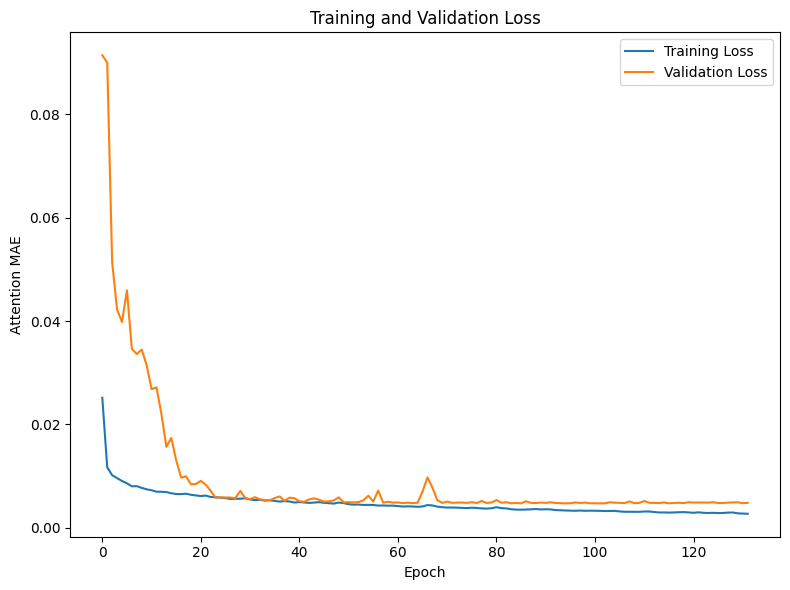

In [21]:
try:
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Attention MAE')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.savefig(os.path.join(model_path, timestamp + ".png"))
    plt.show()
except:
    print("Model did not finish training")

# Metrics

In [22]:
EMSE, EMAE = model.evaluate(test_batches)
print(f"EMSE: {EMSE}\nEMAE: {EMAE}")

6/6 [==============================] - 0s 54ms/step - loss: 0.0047 - attention_mae: 0.0240
EMSE: 0.004737428855150938
EMAE: 0.02398441918194294
